In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are
import math

def env():
    # 系统矩阵A，B
    A = np.array([[0, 10], 
                  [-10, 0]])
    B = np.array([[0], 
                  [1]])
    return A, B
def get_K_and_Gamma():
    A, B = env()
    # 通过ARE求P
    B_sqrt = math.sqrt(2)*B
    Q = np.eye(2)  # State weighting matrix (identity for simplicity)
    R = np.eye(1)  # Control weighting matrix
    P = solve_continuous_are(A, B_sqrt, Q, R)

    # 求反馈增益矩阵K
    K = -np.linalg.inv(R) @ B.T @ P

    # 计算 Γ_i 矩阵
    gamma = P @ B @ B.T @ P

    print("Matrix P:")
    print(P)
    print("Control gain K:")
    print(K)
    return K, gamma, P



In [9]:
import matplotlib.pyplot as plt
import numpy as np



In [10]:
from agent import Agent
from edge import Edge

# 初始化
def init_agents_and_edges(n, m, L, num_agents):
    agents = []
    for i in range(num_agents):
        initial_position = np.random.rand(2, 1) * 10
        agent_i = Agent(n, m, i, initial_position)
        agents.append(agent_i)
    edges = []
    count = 0 # 记录边的index
    for i in range(L.shape[0]):
        for j in range(i + 1, L.shape[1]):
            if L[i][j] == -1:
                agents[i].add_neighbor(count)
                agents[j].add_neighbor(count)
                edge_now = Edge(count, n, m, agents[i], agents[j])
                edges.append(edge_now)
                count += 1
    return agents, edges

def get_neighbor_list(agents):
    neighbor_list = []
    for agent in agents:
        neighbor_list.append(agent.neighbors_edges)
    return neighbor_list

# 测试参数
n = 3  # 假设的参数n
m = 1  # 假设的参数m
L = np.array([[1, -1, 0], [-1, 2, -1], [0, -1, 1]])  # 邻接矩阵
num_agents = 3  # 假设要初始化的agent数量

# 调用待测函数
agents, edges = init_agents_and_edges(n, m, L, num_agents)

# 断言测试结果
# print(len(edges))
assert len(agents) == num_agents, "The number of agents is incorrect."
assert len(edges) == 2, "The number of edges is incorrect."

# 检查agent和edge对象是否正确创建
for i, agent in enumerate(agents):
    assert isinstance(agent, Agent), f"agent {i} is not an instance of Agent"
    # 检查agent的位置是否在正确范围内
    assert np.isscalar(agent.position[0, 0]) and 0 <= agent.position[0, 0] <= 10, "Agent position x is out of bounds."
    assert np.isscalar(agent.position[1, 0]) and 0 <= agent.position[1, 0] <= 10, "Agent position y is out of bounds."

for i, edge in enumerate(edges):
    assert isinstance(edge, Edge), f"edge {i} is not an instance of Edge"
    # 检查edge的索引是否正确
    assert edge.index == i, "Edge index is incorrect."

print(get_neighbor_list(agents))
print("All tests passed!")

[[0], [0, 1], [1]]
All tests passed!


In [11]:
# 定义求睡眠时间的函数
def calculate_sleeping_time(t_start, rho_bar, rho_ij_decay_rate, delta_t, rho_threshold = 0):
    """
    计算睡眠时间，直到 rho 变为 0 或者达到指定的阈值。
    
    参数：
    t_start -- 开始时间
    rho -- 当前边上的状态变量
    rho_threshold -- 目标阈值
    
    返回：
    sleeping_time -- 睡眠时间
    """
    # print(f"rho_bar:{rho_bar}")
    # print(f"rho_ij_decay_rate:{rho_ij_decay_rate}")
    # t = t_start
    # while rho > rho_threshold:
    #     rho -= rho_ij_decay_rate  # 假设 rho 以某个速率衰减到0
    #     t += delta_t
    return rho_bar / (-rho_ij_decay_rate)


In [12]:
# 定义 rho 的演化函数
def get_rho_decay_rate(rho_bar, zeta_ij, zeta_bar, d_i, alpha, theta_ij, gamma_max, p_min):
    
    sign_rho = -np.sign(rho_bar) * (gamma_max / p_min)
    term_1 =  ((d_i / alpha) * zeta_ij + d_i * (d_i - 1) * zeta_bar) * rho_bar**2
    term_2 = 2 * ((d_i / alpha) * zeta_ij + 1) * rho_bar + (d_i / alpha) * zeta_ij + 2 * theta_ij
    # print(f"sign_rho:{sign_rho}")
    # print(f"term_1:{term_1}")
    # print(f"term_2:{term_2}")
    
    return sign_rho * (term_1 + term_2)


# 单元测试
def test_get_rho_decay_rate():
    # 测试正的 rho_bar
    rho_bar = 1.0
    zeta_ij = 0.5
    zeta_bar = 0.3
    d_i = 2
    alpha_i = 1.0
    theta_ij = 0.1
    gamma_max = 10.0
    p_min = 1.0
    
    expected = - (gamma_max / p_min) * (
        ((d_i / alpha_i) * zeta_ij + d_i * (d_i - 1) * zeta_bar) * rho_bar**2 +
        2 * (d_i / alpha_i * zeta_ij + 1) * rho_bar + (d_i / alpha_i) * zeta_ij + 2 * theta_ij
    )
    result = get_rho_decay_rate(rho_bar, zeta_ij, zeta_bar, d_i, alpha_i, theta_ij, gamma_max, p_min)
    assert np.isclose(result, expected), "The calculated rho decay rate is incorrect for positive rho_bar."

test_get_rho_decay_rate()


In [13]:

# 计算u_t
def get_u_t(n, m, K, agent, edges, gamma, delta_t):
    item = np.zeros((n, 1))
    for j in agent.neighbors_edges:
        if agent.index == edges[j].head.index:
            z_ij = edges[j].get_z_ij()
            zeta_ij, _ = edges[j].get_zeta(gamma, delta_t)
            item += zeta_ij * z_ij
        else:
            z_ji = -edges[j].get_z_ij()
            _, zeta_ji = edges[j].get_zeta(gamma, delta_t)
            item += zeta_ji * z_ji
    u_t = K @ item
    return u_t

# 计算zeta_bar
def get_zeta_bar(agent, edges, gamma, delta_t):
    zeta_bar, _ = edges[agent.neighbors_edges[0]].get_zeta(gamma, delta_t)
    for i in agent.neighbors_edges:
        if agent.index == edges[i].head.index:
            item, _ = edges[i].get_zeta(gamma, delta_t)
        else:
            _, item = edges[i].get_zeta(gamma, delta_t)
        zeta_bar = max(zeta_bar, item)
    return zeta_bar

In [14]:
def plot_theta_evolution(time_points_dict, theta_values):
    """
    画出自适应变量 θij 的演变曲线。
    
    参数：
    - time_points_dict: 字典，key 为 edge 对象，value 为对应的时间点列表
    - theta_values: 字典，key 为 edge 对象，value 为对应的 θij 值列表，其中包含两个值
    """
    plt.figure(figsize=(10, 6))

    # 绘制每个边的 θij 演变曲线
    for edge, theta in theta_values.items():
        time_points = time_points_dict[edge]
        label_head_tail = f'θ{edge.head.index}{edge.tail.index}'
        label_tail_head = f'θ{edge.tail.index}{edge.head.index}'
        plt.plot(time_points, [val[0] for val in theta], label=label_head_tail)
        plt.plot(time_points, [val[1] for val in theta], label=label_tail_head)

    # 设置图形标签和标题
    plt.xlabel('Time t')
    plt.ylabel('θij(t) ∈ ℰ')
    plt.title('Evolution of θij')
    plt.legend()
    plt.grid(True)

    # 显示图形
    plt.show()

Matrix P:
[[1.00869975 0.04975247]
 [0.04975247 0.99876158]]
Control gain K:
[[-0.04975247 -0.99876158]]
-------------agent_1和agent_3边被触发-------------
t:0.015
agent_1的position:[[3.17401419]
 [2.74310775]]
agent_3的position:[[7.68648195]
 [4.54992181]]
-------------agent_1和agent_3边被触发-------------
t:0.02
agent_1的position:[[3.31116958]
 [2.61018022]]
agent_3的position:[[7.91397804]
 [4.17087987]]
-------------agent_0和agent_1边被触发-------------
t:0.025
agent_0的position:[[6.62097995]
 [6.06595806]]
agent_1的position:[[4.09422365]
 [2.13194721]]
-------------agent_1和agent_2边被触发-------------
t:0.025
agent_1的position:[[4.73380781]
 [1.52681421]]
agent_2的position:[[4.17516369]
 [8.81026228]]
-------------agent_1和agent_3边被触发-------------
t:0.025
agent_1的position:[[4.81014852]
 [1.39692513]]
agent_3的position:[[8.12252203]
 [3.77679642]]
-------------agent_2和agent_3边被触发-------------
t:0.025
agent_2的position:[[6.81824237]
 [6.65733738]]
agent_3的position:[[9.25556096]
 [1.43038831]]
-------------agent_0

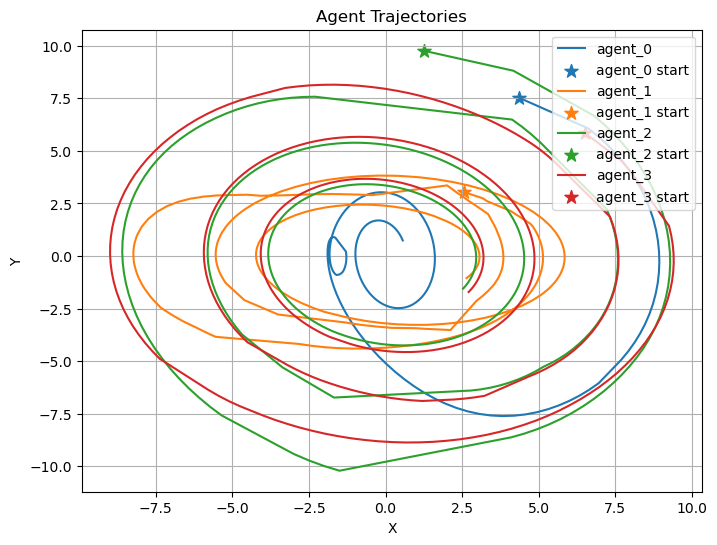

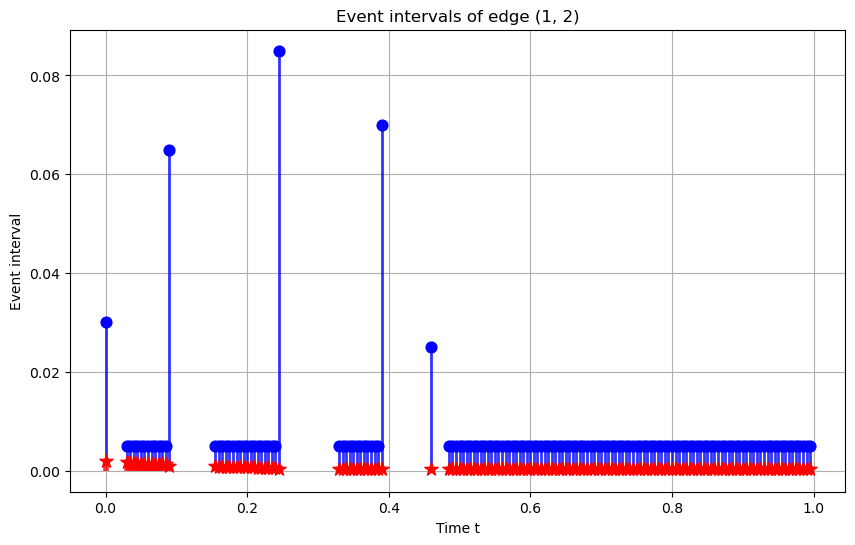

d:\application\anaconda\envs\pytorch\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


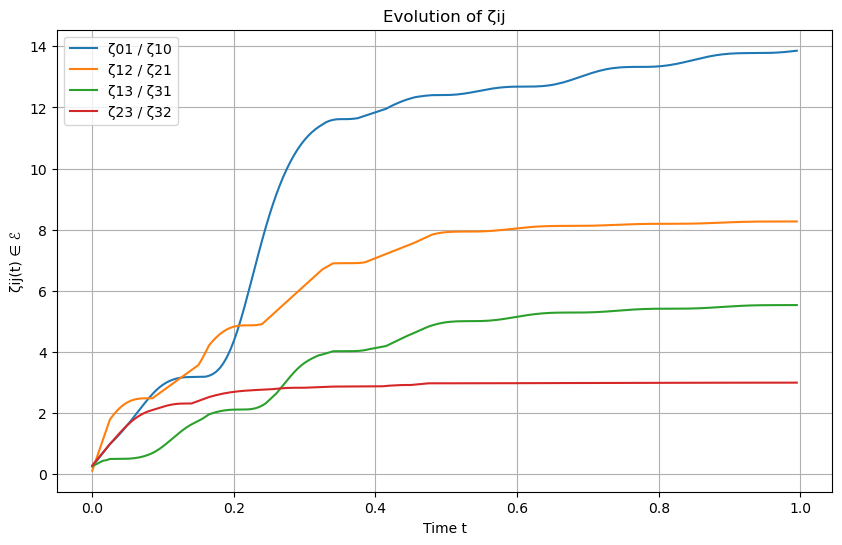

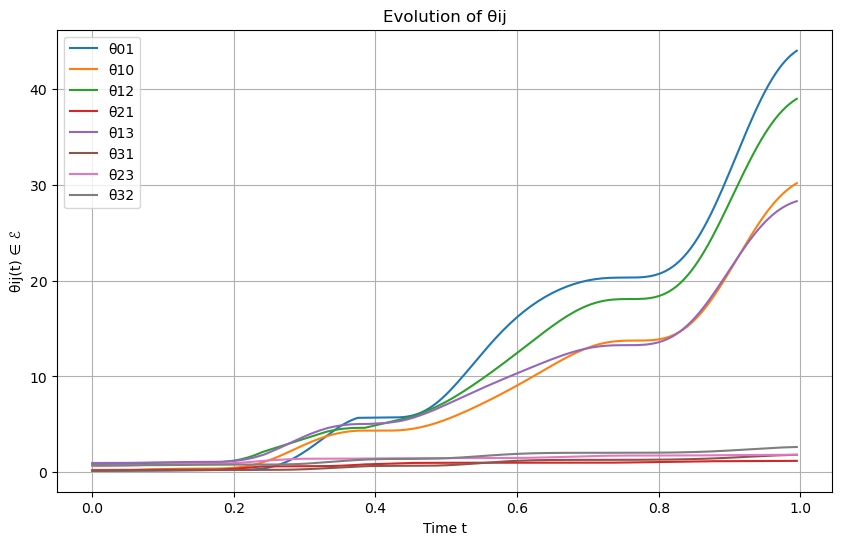

In [ ]:
import copy
import agent
import plot
# 仿真参数
delta_t = 0.005  # 时间间隔
T_max = 1  # 仿真运行总时间
alpha = 0.5

# 初始化
num_agents = 4
n = 2
m = 1
A, B = env()
# L矩阵
L = np.array([
    [1, -1, 0, 0],
    [-1, 3, -1, -1],
    [0, -1, 2, -1],
    [0, -1, -1, 2]
])
K, gamma, P = get_K_and_Gamma()
agents, edges = init_agents_and_edges(n, m, L, num_agents)

# 用来记录所有agent的轨迹
agents_trajectories = {f"agent_{agent_index}" : [] for agent_index in range(num_agents)}
for i in range(num_agents): # 记录agent的初始位置
    i_position = agents[i].position
    agents_trajectories[f"agent_{i}"].append(copy.deepcopy(i_position))


delta_t_tau = {edge: 0 for edge in edges}  # 跟踪每个边自上次事件以来的时间

event_sleep_time = {edge: 0 for edge in edges} # 记录当前边上的睡眠时间，用于判断是否触发通信函数

event_trigger_time = {edge: [] for edge in edges}  # 用来记录事件的触发时间

event_sleep_time_recording = {edge: [] for edge in edges} # 记录每次事件触发后的睡眠时间

delta_t_tau_recording = {edge: [] for edge in edges} # 记录每次事件触发后的自上次事件以来的时间 

edges_zeta_recording = {edge: [] for edge in edges} # 记录每次事件触发后的ζ

edges_theta_recording = {edge: [] for edge in edges} # 记录每次事件触发后的θ

# 记录初始的ζ和θ
for edge in edges:
    event_trigger_time[edge].append(0)
    edges_zeta_recording[edge].append(edge.zeta_ij)
    item = [edge.theta_ij, edge.theta_ji]
    edges_theta_recording[edge].append(item)


# 模拟多智能体系统的动态演化过程
for t in np.arange(0, T_max, delta_t):
    for edge in edges:
        # 记录每个边自上次事件以来的时间
        delta_t_tau[edge] += delta_t

        # 该边没有达到睡眠时间就退出本次循环
        if delta_t_tau[edge] < event_sleep_time[edge]:
            continue
        
        # ---------------------达到睡眠时间，看看通信函数是否触发(Φ<0)------------------------------
        agent_i = edge.head
        agent_j = edge.tail
        # 计算u_i,u_j
        u_i = get_u_t(n, m, K, agent_i, edges, gamma, delta_t_tau[edge])
        u_j = get_u_t(n, m, K, agent_j, edges, gamma, delta_t_tau[edge])
        # print(f"u_i.shape:{u_i.shape}")
        # 计算两个agent之间的触发时间差z_ij
        z_ij = edge.get_z_ij()
        z_ji = -z_ij
        # print(f"z_ij.shape:{z_ij.shape}")

        # 计算e_ij和e_ji,为了描述估计误差
        e_ij, e_ji = edge.get_e(A, B, delta_t_tau[edge], u_i, u_j)
        # print(f"e_ij.shape:{e_ij.shape}")

        # 计算触发界限θ
        theta_ij, theta_ji = edge.get_theta(e_ij, e_ji, gamma, delta_t_tau[edge])
        # print(f"theta_ij.shape:{theta_ij.shape}")

        # 计算ζ_ij,ζ_ji
        zeta_ij, zeta_ji = edge.get_zeta(gamma, delta_t_tau[edge])
        # print(f"zeta_ij.shape:{zeta_ij.shape}") # 1*1

        # 计算通信触发函数Φ_ij,Φ_ji
        d_i = agent_i.neighbors_num
        d_j = agent_j.neighbors_num
        phi_ij = (0.5 * alpha / d_i) * zeta_ij @ z_ij.T @ gamma @ z_ij + zeta_ij @ z_ij.T @ gamma @ e_ij - theta_ij @ e_ij.T @ gamma @ e_ij
        phi_ji = (0.5 * alpha / d_j) * zeta_ji @ z_ji.T @ gamma @ z_ji + zeta_ji @ z_ji.T @ gamma @ e_ji - theta_ji @ e_ji.T @ gamma @ e_ji
        
        # 如果两头Φ都大于0，通信无法触发，退出本次循环
        if phi_ij > 0 and phi_ji > 0:
            continue
        
        # -----------------------------------以下为通信触发时刻-----------------------------------
        print(f"-------------agent_{edge.head.index}和agent_{edge.tail.index}边被触发-------------")
        # ----------------------------计算参数-------------------------------
        # 计算矩阵P，gamma的特征值
        P_eigenvalues = np.linalg.eigvals(P) # P 的特征值
        gamma_eigenvalues = np.linalg.eigvals(gamma) # gamma 的特征值
        p_min = np.min(P_eigenvalues)
        gamma_max = np.max(gamma_eigenvalues)

        # 计算zeta_bar = max(zeta)
        zeta_i_bar = get_zeta_bar(agent_i, edges, gamma, delta_t_tau[edge])
        zeta_j_bar = get_zeta_bar(agent_j, edges, gamma, delta_t_tau[edge])
        # print(f"zeta_i_bar:{zeta_i_bar}")

        # 计算当前边的睡眠时间
        rho_ij_decay_rate = get_rho_decay_rate(edge.rho_ij_bar, zeta_ij, zeta_i_bar, d_i, alpha, theta_ij, gamma_max, p_min)
        rho_ji_decay_rate = get_rho_decay_rate(edge.rho_ji_bar, zeta_ji, zeta_j_bar, d_j, alpha, theta_ji, gamma_max, p_min)
        ij_sleep_time = calculate_sleeping_time(t, edge.rho_ij_bar, rho_ij_decay_rate, delta_t)
        ji_sleep_time = calculate_sleeping_time(t, edge.rho_ij_bar, rho_ji_decay_rate, delta_t)
        sleep_time = min(ij_sleep_time, ji_sleep_time)

        # 计算触发后agent_i和agent_j的位置
        agent_i.update_position( A, B, u_i, delta_t_tau[edge])
        agent_j.update_position( A, B, u_j, delta_t_tau[edge])
        
        # -------------------------记录参数------------------------------------
        
        # 记录当前边的睡眠时间和自上次事件以来的时间
        event_sleep_time_recording[edge].append(sleep_time)
        delta_t_tau_recording[edge].append(delta_t_tau[edge])
        
        # 记录当前边的触发时刻
        event_trigger_time[edge].append(t)
        
        # 记录当前边的ζ和θ
        edges_zeta_recording[edge].append(zeta_ij)
        item = [theta_ij, theta_ji]
        edges_theta_recording[edge].append(item)


        
        # 记录当前时刻agent_i和agent_j的位置
        i_index = agent_i.index
        i_position = agent_i.position
        # i_position = np.reshape(1, -1)
        agents_trajectories[f"agent_{i_index}"].append(copy.deepcopy(i_position))
        j_index = agent_j.index
        j_position = agent_j.position
        # j_position = np.reshape(1, -1)
        agents_trajectories[f"agent_{j_index}"].append(copy.deepcopy(j_position))
        print(f"t:{t}")
        print(f"agent_{i_index}的position:{i_position}")
        print(f"agent_{j_index}的position:{j_position}")

        # -----------------------------更新参数----------------------------
        # 更新edge参数
        edge.update_data(agent_i, agent_j, z_ij, zeta_ij, zeta_ji, e_ij, e_ji, theta_ij, theta_ji)
        
        # 更新当前边的睡眠时间和上次触发时刻以来的时间delta_t_tau
        event_sleep_time[edge] = sleep_time
        delta_t_tau[edge] = 0 

# print("Final positions of the agents:")
# print("agents_trajectories:")
# for key in agents_trajectories.keys():
#     print(key + ":")
#     print(agents_trajectories[key])

plot.plot_agent_trajectories(agents_trajectories)
# print(f"event_sleep_time_recording[edges[1]]：{event_sleep_time_recording[edges[1]]}")
# 绘制edge（1，2） 的触发时间间隔
plot.plot_event_intervals(edges[1].head.index, edges[1].tail.index, event_sleep_time_recording[edges[1]], delta_t_tau_recording[edges[1]])
plot.plot_evolution(event_trigger_time, edges_zeta_recording)
plot_theta_evolution(event_trigger_time, edges_theta_recording)